# Molecular mechnism of earliest and fastest appearance of megakaryocytes

In this tutorial, we will guide you to
- visualize topography with computed fixed points and manually filtered fixed points
- visualize vector field pseudotime


Import relevant packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import Scribe as sb
import sys
import os

# import scanpy as sc
import dynamo as dyn
import seaborn as sns

dyn.dynamo_logger.main_silence()

# filter warnings for cleaner tutorials
import warnings
warnings.filterwarnings('ignore')


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
adata_labeling = dyn.sample_data.hematopoiesis()


take a glance at what is in `adata` object. All observations, embedding layers and other data in `adata` are computed within `dynamo`. Please refer to other dynamo tutorials regarding how to obtain these values from metadata and raw new/total and (or) raw spliced/unspliced gene expression values.

## Schematic of leveraging differential geometry 
- ranking genes (using either raw or absolute values) across all cells or in each cell group/state
- gene set enrichment, network construction, and visualization
- identifying top toggle-switch pairs driving cell fate bifurcations

![fig5_A](images/fig5_A.png)

## Visualize topography


### Lineage tree of hematopoiesis, lumped automatically from the vector field built in the UMAP space

![fig5_C](images/fig5_C.png)


### The reconstructed vector field and associated fixed points. 
The color of digits in each node reflects the type of fixed point: red, emitting fixed point; black, absorbing fixed point. The color of the numbered nodes corresponds to the confidence of the fixed points.

#### Manually select good fixed points found by topography.

In [3]:
adata_labeling.uns['VecFld_umap'].keys()

dict_keys(['C', 'E_traj', 'P', 'V', 'VFCIndex', 'X', 'X_ctrl', 'X_data', 'Xss', 'Y', 'beta', 'confidence', 'ctrl_idx', 'ftype', 'grid', 'grid_V', 'iteration', 'method', 'nullcline', 'sigma2', 'tecr_traj', 'valid_ind', 'xlim', 'ylim'])

In [4]:
dyn.vf.topography(adata_labeling, n=250, basis='umap');


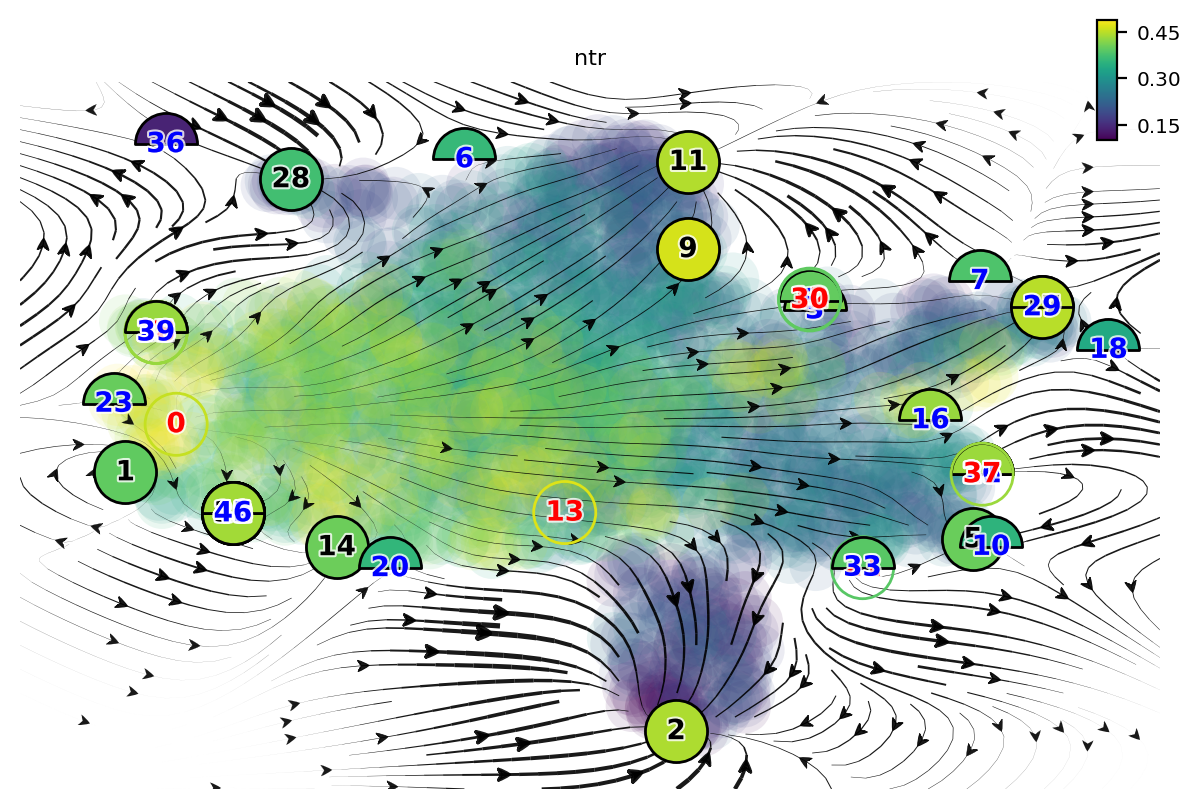

In [5]:
dyn.pl.topography(
    adata_labeling,
    markersize=500,
    basis="umap",
    fps_basis="umap",
    streamline_alpha=0.9,
)

In the resulted dictionary, `Xss` stands for the fixed points coordinates and `ftype` is the specific fixed point type, denoted by integers.  
ftype value mapping:  
- -1: stable
- 0: saddle
- 1: unstable

In [6]:
Xss, ftype = adata_labeling.uns['VecFld_umap']['Xss'], adata_labeling.uns['VecFld_umap']['ftype']
good_fixed_points = [0, 2, 5, 29, 11, 28]

adata_labeling.uns['VecFld_umap']['Xss'] = Xss[good_fixed_points]
adata_labeling.uns['VecFld_umap']['ftype'] = ftype[good_fixed_points]


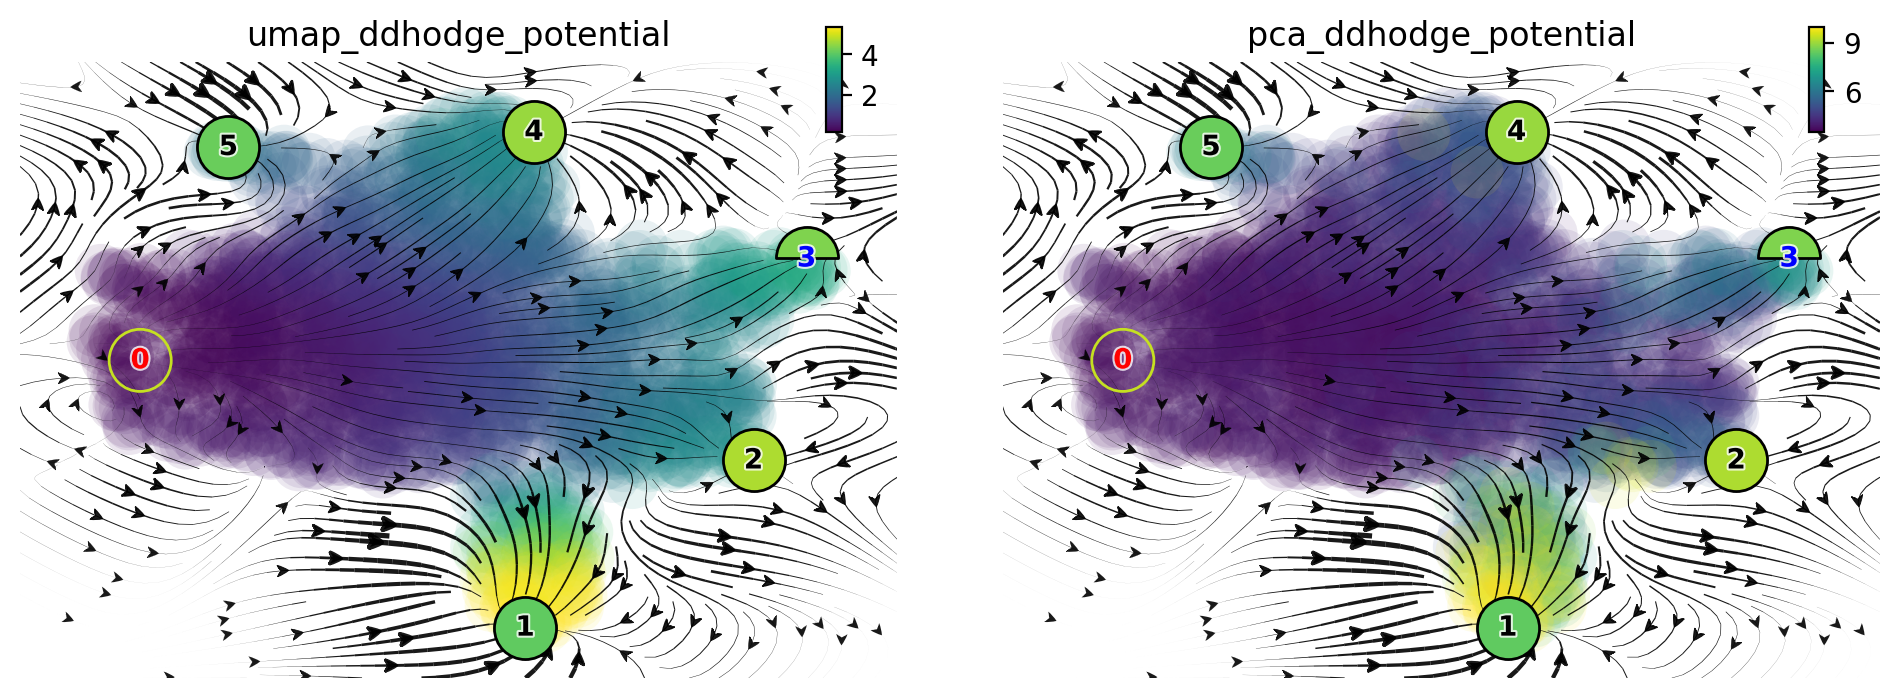

In [7]:
dyn.pl.topography(
    adata_labeling,
    markersize=500,
    basis="umap",
    fps_basis="umap",
    #   color=['pca_ddhodge_potential'],
    color=["umap_ddhodge_potential", "pca_ddhodge_potential"],
    streamline_alpha=0.9,
)


## Vector field pseudotime

In this section, we will show how to visualize vector field pseudotime with `dynamo`. The vector field pseudotime is calculated based on the velocity transition matrix.

**Define a colormap we will use later**

In [8]:
dynamo_color_dict = {
    "Mon": "#b88c7a",
    "Meg": "#5b7d80",
    "MEP-like": "#6c05e8",
    "Ery": "#5d373b",
    "Bas": "#d70000",
    "GMP-like": "#ff4600",
    "HSC": "#c35dbb",
    "Neu": "#2f3ea8",
}


**Initialize a dataframe object we will use to plot with visualization packages such as `sns`**

In [9]:
valid_cell_type = ["HSC", "MEP-like", "Meg", "Ery", "Bas"]
valid_indices = adata_labeling.obs["cell_type"].isin(valid_cell_type)
df = adata_labeling[valid_indices].obs[["pca_ddhodge_potential", "umap_ddhodge_potential", "cell_type"]]
df["cell_type"] = list(df["cell_type"])

### Building a graph, computing divergence and potential with `graph_operators` in `dynamo`

In [10]:
from dynamo.tools.graph_operators import build_graph, div, potential
g = build_graph(adata_labeling.obsp["cosine_transition_matrix"])
ddhodge_div = div(g)
potential_cosine = potential(g, -ddhodge_div)
adata_labeling.obs["cosine_potential"] = potential_cosine

df["cosine"] = potential_cosine[valid_indices]


Compute `potential_fp` and store in the dataframe object `df` we created above. Note that `fp` stands for `fokkerplanck`. Please refer to the `dynamo` cell paper for more details on the related methods.

Text(0.5, 9.444444444444438, 'vector field pseudotime')

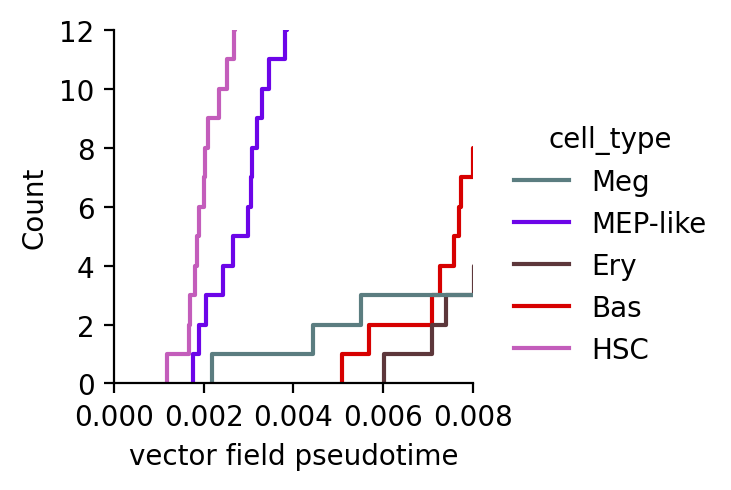

In [11]:
g = build_graph(adata_labeling.obsp["fp_transition_rate"])

ddhodge_div = div(g)
potential_fp = potential(g, -ddhodge_div)
df["fp"] = potential_fp[valid_indices]

sns.displot(
    data=df,
    x="cosine",
    hue="cell_type",
    kind="ecdf",
    stat="count",
    palette=dynamo_color_dict,
    height=2.5,
    aspect=95.5 / 88.8,
)
plt.xlim(0.0, 0.008)
plt.ylim(0, 12)

plt.xlabel("vector field pseudotime")


With the visualization results, we can observe that egakaryocytes appear earliest among the Meg, Ery, and Bas lineages. 

## Molecular mechanisms underlying the early appearance of the Meg lineage

In this section, we will show:
- Self- activation of FLI1
- Repression of KLF1 by FLI1
- FLI1 represses KLF1
- Schematic summarizing the interactions involving FLI1 and KLF1.

In [12]:
Meg_genes = ["FLI1", "KLF1"]


**Compute jacobian of selected genes**

In [13]:
dyn.vf.jacobian(adata_labeling, regulators=Meg_genes, effectors=Meg_genes);


Transforming subset Jacobian: 100%|██████████| 1947/1947 [00:00<00:00, 132999.62it/s]


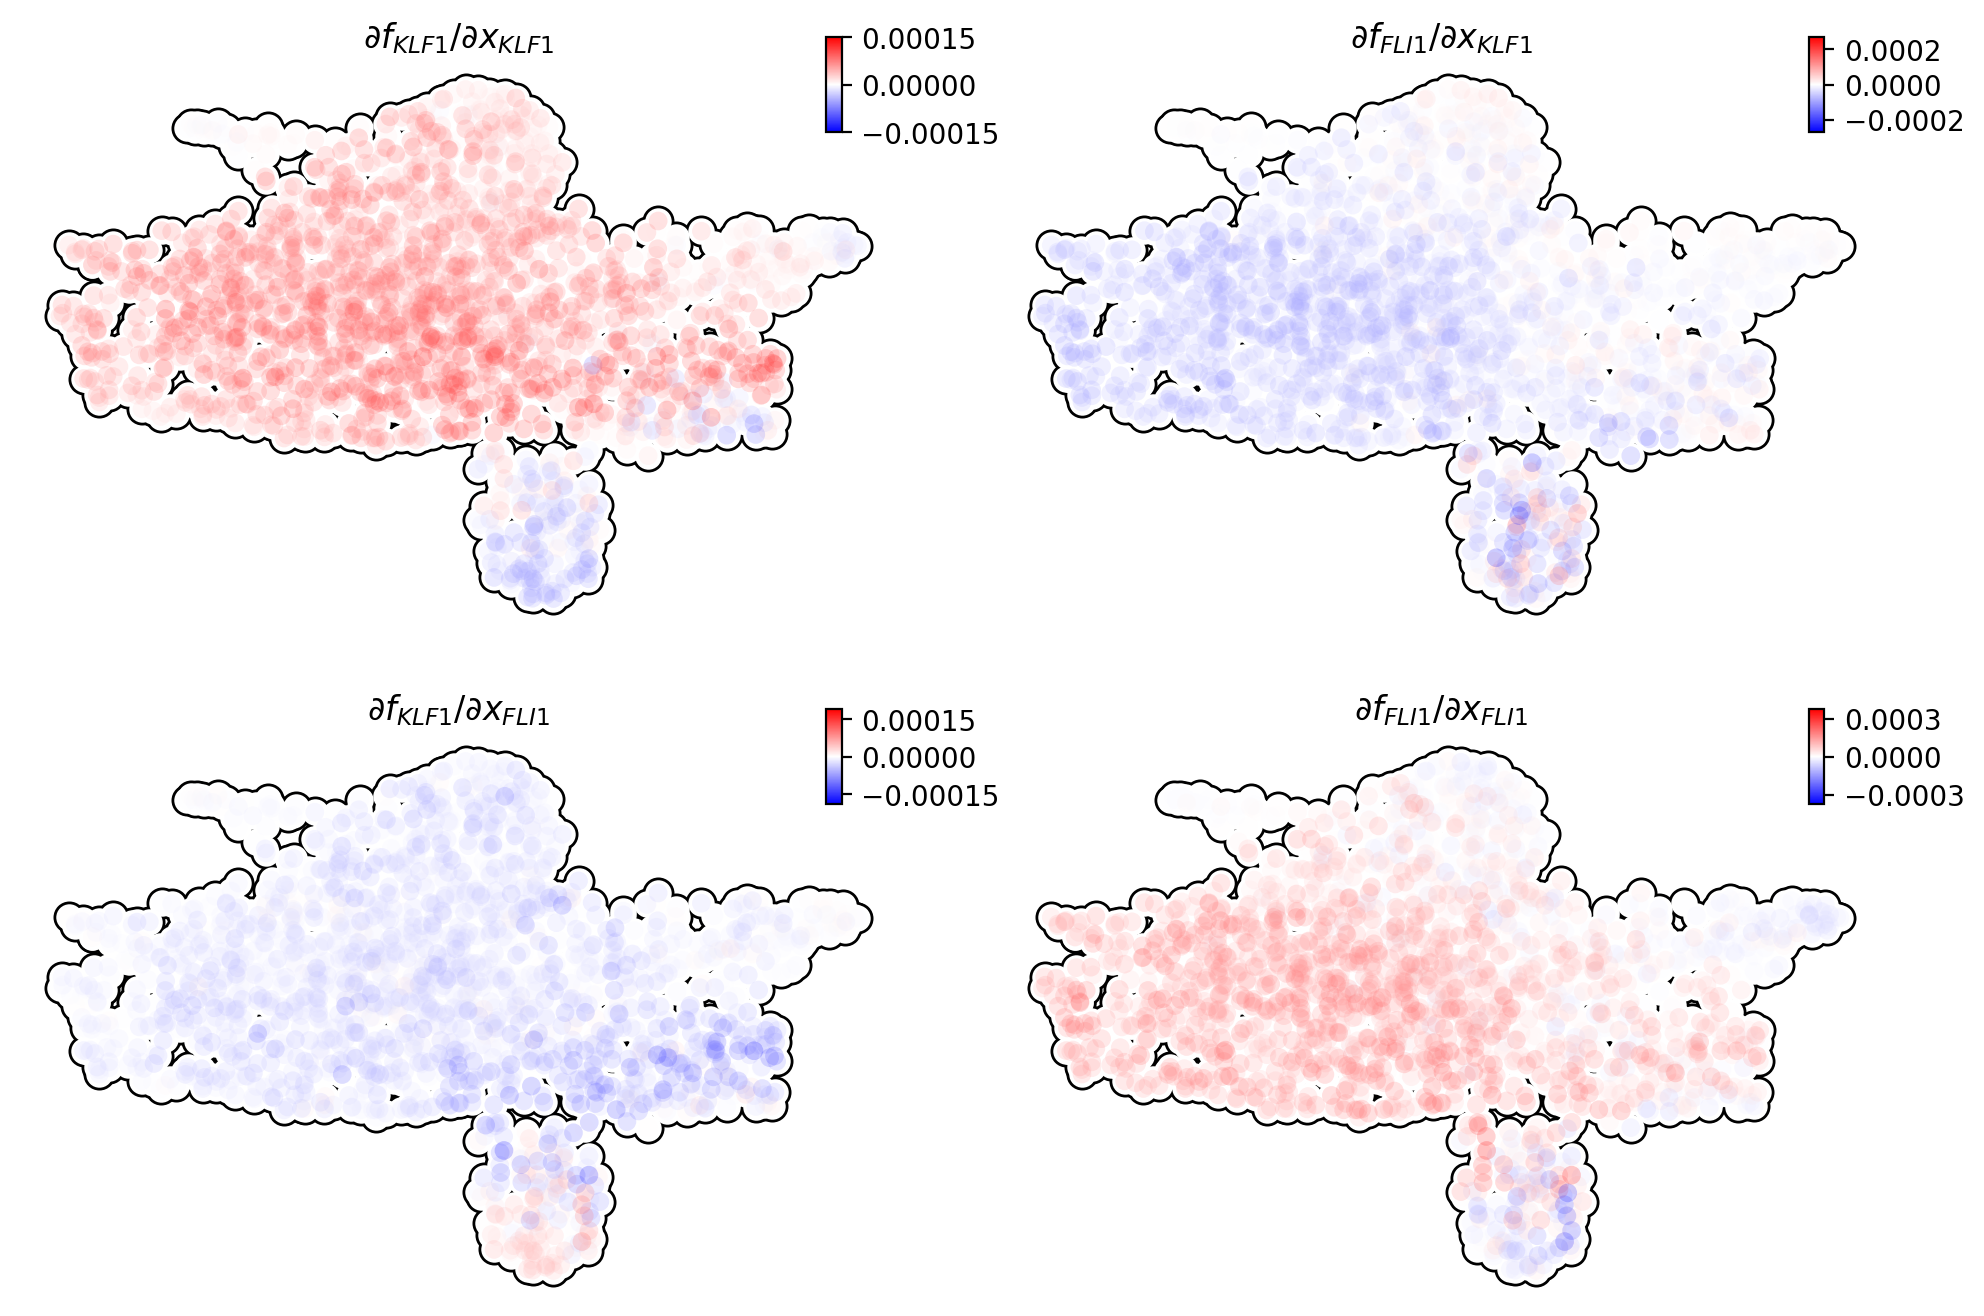

In [14]:

dyn.pl.jacobian(
    adata_labeling,
    regulators=Meg_genes,
    basis="umap",
)


### Schematic summarizing the interactions involving FLI1 and KLF1

![fig5_f_iv](images/fig5_f_iv.png)